## Package

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

## Dataset Loading

In [2]:
batch_size = 16
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "data/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "data/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "data/test", batch_size=batch_size
)


Found 720 files belonging to 2 classes.
Using 576 files for training.
Found 720 files belonging to 2 classes.
Using 144 files for validation.
Found 180 files belonging to 2 classes.


In [3]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b"I believe that everyone should take this vaccine if they do not have any difficulties. Efficacies of this vaccine is 60-90% so it will be much better if we take this for gaining this amount of immunity into our body. I'll encourage those people who are poor and older than 40. Have a safe and healthy life to all of you."
1
b'No good news from the users. All the good reviews have come from those people who are actually selling it. So, there is no reason to support this vaccine.'
0
b'The vaccine is an experimental vaccine so of course there\xe2\x80\x99s going to be liability to the people who take it.'
0
b'I have not faced any side effects of this vaccine. Vaccine is good and I suggest my friends and my nearby people take the vaccine as soon as possible.'
1
b'Overall, the government vaccine rollout seems to be well-coordinated. However, the myths around vaccines should be vigorously tackled by politicians and other political leaders as I know plenty of people who are not registering for

## Data Pre-Processing

In [4]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

max_features = 20000
embedding_dim = 128
sequence_length = 500

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

text_ds = raw_train_ds.map(lambda x, y: x)

vectorize_layer.adapt(text_ds)

In [5]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)


In [6]:
## Models

In [7]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")

x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)


x = layers.Conv1D(256, 7, padding="valid", activation="relu", strides=1)(x)
#x = layers.GlobalMaxPooling1D()(x)

x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=1)(x)
x = layers.GlobalMaxPooling1D()(x)

x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)

predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         229632    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         229504    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256  

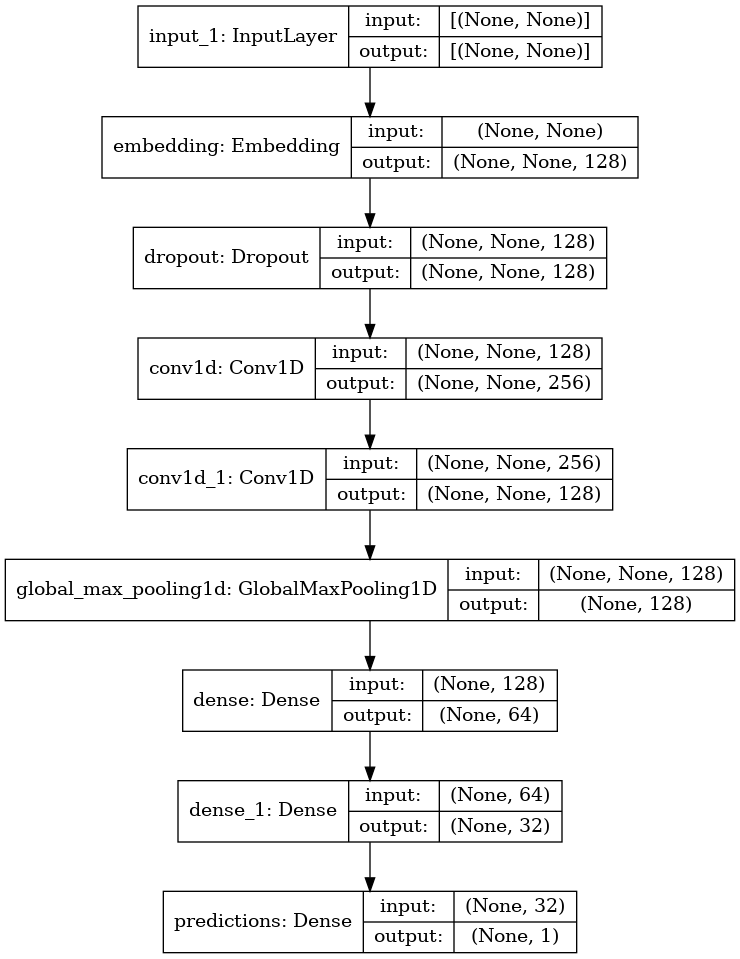

In [9]:
tf.keras.utils.plot_model(model, to_file='deep.png', show_shapes=True)

In [10]:
earlyStopCb = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=3)
nn_histroy=model.fit(train_ds, validation_data=val_ds, epochs=100,callbacks=[earlyStopCb])

Epoch 1/100
36/36 [==============================] - 6s 55ms/step - loss: 0.6966 - accuracy: 0.4763 - val_loss: 0.6946 - val_accuracy: 0.4444
Epoch 2/100
36/36 [==============================] - 1s 36ms/step - loss: 0.6807 - accuracy: 0.5596 - val_loss: 0.6514 - val_accuracy: 0.6667
Epoch 3/100
36/36 [==============================] - 1s 37ms/step - loss: 0.4991 - accuracy: 0.7667 - val_loss: 0.5759 - val_accuracy: 0.7083
Epoch 4/100
36/36 [==============================] - 1s 35ms/step - loss: 0.1983 - accuracy: 0.9076 - val_loss: 0.6954 - val_accuracy: 0.7431
Epoch 5/100
36/36 [==============================] - 1s 35ms/step - loss: 0.0683 - accuracy: 0.9752 - val_loss: 0.9405 - val_accuracy: 0.7292
Epoch 6/100
36/36 [==============================] - 1s 37ms/step - loss: 0.0303 - accuracy: 0.9881 - val_loss: 1.0762 - val_accuracy: 0.7500
Epoch 7/100
36/36 [==============================] - 1s 35ms/step - loss: 0.0357 - accuracy: 0.9891 - val_loss: 1.2154 - val_accuracy: 0.7361
Epoch 

In [11]:
model.evaluate(test_ds)

12/12 [==============================] - 2s 13ms/step - loss: 0.9287 - accuracy: 0.8056


[0.9287163019180298, 0.8055555820465088]

In [12]:
for text_batch, label_batch in test_ds.take(1):
    y_test = label_batch